# ANALYZING THE REVIEWS SONY'S NOISE CANCELLING HEADPHONE

In this project, we will analyze data from approximately 1200 reviews of Sony's flagship headphones, the Sony WH-1000XM5, to identify common likes and dislikes among general consumers. The dataset was obtained through web scraping using the "Amazon Reviews Scraper" tool on Apify.com and is based on reviews as of 25/02/2023. 

**Disclaimer:** **It is important to note that this analysis should not be considered a comprehensive representation of public opinion on the Sony headphones, but rather my demonstration of skills learned in a marketing analysis course.**

In [1]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
import seaborn as sns

nltk.download('vader_lexicon')
nltk.download('punkt')

from collections import Counter

from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

stop_words = set(stopwords.words('english'))
lem = WordNetLemmatizer()
sid = SentimentIntensityAnalyzer()
snow = SnowballStemmer('english')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/repl/nltk_data...
[nltk_data] Downloading package punkt to /home/repl/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/repl/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/repl/nltk_data...


In [2]:
sony  = pd.read_json('sony2.json')

In [3]:
sony.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   productAsin        1244 non-null   object        
 1   username           1244 non-null   object        
 2   ratingScore        1244 non-null   int64         
 3   reviewTitle        1244 non-null   object        
 4   reviewUrl          804 non-null    object        
 5   reviewReaction     1244 non-null   object        
 6   reviewedIn         1244 non-null   object        
 7   date               1244 non-null   datetime64[ns]
 8   country            1244 non-null   object        
 9   countryCode        690 non-null    object        
 10  reviewDescription  1244 non-null   object        
 11  isVerified         1244 non-null   bool          
 12  avatar             1244 non-null   object        
 13  variant            1244 non-null   object        
 14  reviewIm

### Preview of the data

In [4]:
sony.head(10)

,productAsin,username,ratingScore,reviewTitle,reviewUrl,reviewReaction,reviewedIn,date,country,countryCode,reviewDescription,isVerified,avatar,variant,reviewImages,position
0,B09XSDMT4F,kcdkcd,4,"Not bad, but I expected a little better if I'm...",https://www.amazon.com/gp/customer-reviews/R2N...,32 people found this helpful,"Reviewed in the United States on February 10, ...",2023-02-10,United States,None,I'm a hobbyist musician and sound engineer of ...,True,https://images-na.ssl-images-amazon.com/images...,Color: Black,[https://m.media-amazon.com/images/I/61z9O09Xr...,1
1,B09XSDMT4F,Bast,5,"Smaller heads, folks with hair, and sensitive ...",https://www.amazon.com/gp/customer-reviews/REW...,54 people found this helpful,"Reviewed in the United States on January 18, 2023",2023-01-18,United States,None,"First off, I havent had a chance to test all f...",True,https://images-na.ssl-images-amazon.com/images...,Color: Black,[https://m.media-amazon.com/images/I/61z9O09Xr...,2
2,B09XSDMT4F,Richard HuynhRichard Huynh,5,Sony never disappoints!,https://www.amazon.com/gp/customer-reviews/R36...,71 people found this helpful,"Reviewed in the United States on November 24, ...",2022-11-24,United States,None,I thoroughly enjoy what Sony has to offer in t...,True,https://images-na.ssl-images-amazon.com/images...,Color: Black,[https://m.media-amazon.com/images/I/61z9O09Xr...,3
3,B09XSDMT4F,mhans311,4,Comparison to Bose NC700,https://www.amazon.com/gp/customer-reviews/R31...,41 people found this helpful,"Reviewed in the United States on February 4, 2023",2023-02-04,United States,None,"I have used Bose NC700 for the past year, but ...",True,https://images-na.ssl-images-amazon.com/images...,Color: Silver,[https://m.media-amazon.com/images/I/61z9O09Xr...,4
4,B09XSDMT4F,Fresh and Felicia,5,"UNBELIEVABLE carbon fiber sound quality, impro...",https://www.amazon.com/gp/customer-reviews/R1Z...,768 people found this helpful,"Reviewed in the United States on May 24, 2022",2022-05-24,United States,None,"I own Sony’s WH-1000 XM4s and the Bose 700s, t...",True,https://images-na.ssl-images-amazon.com/images...,Color: Black,[https://m.media-amazon.com/images/I/61z9O09Xr...,5
5,B09XSDMT4F,Worm,4,It’s not 100% Noise Cancellation,https://www.amazon.com/gp/customer-reviews/R2Y...,8 people found this helpful,"Reviewed in the United States on January 16, 2023",2023-01-16,United States,None,"If you want 100% Noise Cancellation, use ear p...",True,https://images-na.ssl-images-amazon.com/images...,Color: Black,[https://m.media-amazon.com/images/I/61z9O09Xr...,6
6,B09XSDMT4F,Laurent Park,4,Incredibly comfortable and versatile headphone...,https://www.amazon.com/gp/customer-reviews/RBJ...,2 people found this helpful,"Reviewed in the United States on February 4, 2023",2023-02-04,United States,None,I got this looking for a replacement for my Ai...,True,https://images-na.ssl-images-amazon.com/images...,Color: Silver,[https://m.media-amazon.com/images/I/61z9O09Xr...,7
7,B09XSDMT4F,Miki Villarreal,5,I have fallen in love,https://www.amazon.com/gp/customer-reviews/R2K...,24 people found this helpful,"Reviewed in the United States on December 21, ...",2022-12-21,United States,None,I have been looking for some good over the ear...,True,https://images-na.ssl-images-amazon.com/images...,Color: Silver,[https://m.media-amazon.com/images/I/61z9O09Xr...,8
8,B09XSDMT4F,Brandi J.,5,The best headphones I've ever owned,https://www.amazon.com/gp/customer-reviews/R3L...,One person found this helpful,"Reviewed in the United States on February 1, 2023",2023-02-01,United States,None,I went ahead and splurged on these around 3 to...,True,https://images-na.ssl-images-amazon.com/images...,Color: Black,[https://m.media-amazon.com/images/I/61z9O09Xr...,9
9,B09XSDMT4F,Blayre C.,5,"Yep, buy them. Just do it.",https://www.amazon.com/gp/customer-reviews/R1F...,7 people found this helpful,"Reviewed in the United States on February 3, 2023",2023-02-03,United States,None,If you're thinking about buying a pa

We have noticed that some values are missing in the "reviewUrl" and "countryCode" columns of our dataset. However, since these columns are not necessary for our analysis, we can simply drop them from the dataset using the "drop" function in pandas. 

The code to drop these columns would look like this:

In [5]:
sony.isna().sum()

productAsin            0
username               0
ratingScore            0
reviewTitle            0
reviewUrl            440
reviewReaction         0
reviewedIn             0
date                   0
country                0
countryCode          554
reviewDescription      0
isVerified             0
avatar                 0
variant                0
reviewImages           0
position               0
dtype: int64

In [6]:
sony_clean = sony.drop(columns = ['productAsin', 'reviewedIn', 'countryCode', 'reviewImages','reviewUrl', 'avatar', 'reviewReaction'])
sony_clean['variant'] = sony_clean['variant'].str.replace('Color:', '').str.strip()

### OVERALL AVERAGE RATING

In [7]:
#overall rating score 
print(sony_clean['ratingScore'].mean())

3.9565916398713825


The average rating score for reviews that include a written review is 3.94 out of 5 stars. While this score does not represent all the reviews of the product, it is still a positive indication of its quality. This suggests that the product is generally well-received by consumers who take the time to write a review.

### AMOUNT OF REVIEW BY LOCATION AND PRODUCT VARIANT

Text(0.5, 1.0, 'Review count overtime since product launch')

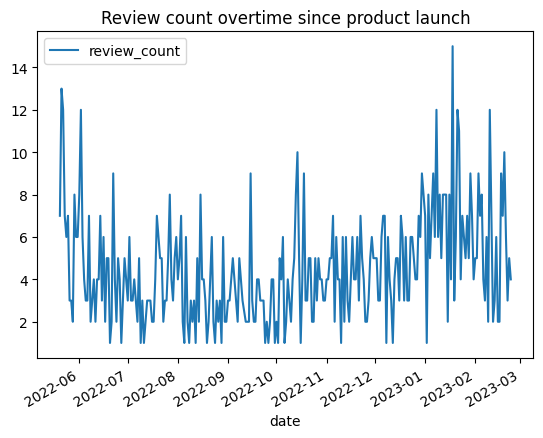

In [8]:
#amount of reviews overtime 
review_count_by_date = sony_clean.groupby('date').agg(review_count = ('position', 'count'))
review_count_by_date.plot()
plt.title('Review count overtime since product launch')

### We have generated a plot showing the count of reviews over time. This plot displays the number of reviews of the Sony WH-1000XM5 headphones that were posted on Amazon over a period of time. This information can help us understand trends in consumer interest in the product and identify any spikes or drops in review activity.

**Findings**

- The product reviews for the Sony WH-1000XM5 headphones started appearing around the 5th month of 2022, which aligns with the product's release date of May 2022.
- We also observe an increase in review activity around the time of the product's release, which may be attributed to loyal Sony customers who were eager to get their hands on the new headphones. 
- The increase in reviews at around December 2022 - January 2023 could be explained by the holiday season at the end of the year, during which time the product may have been purchased as a gift.

<AxesSubplot: xlabel='country'>

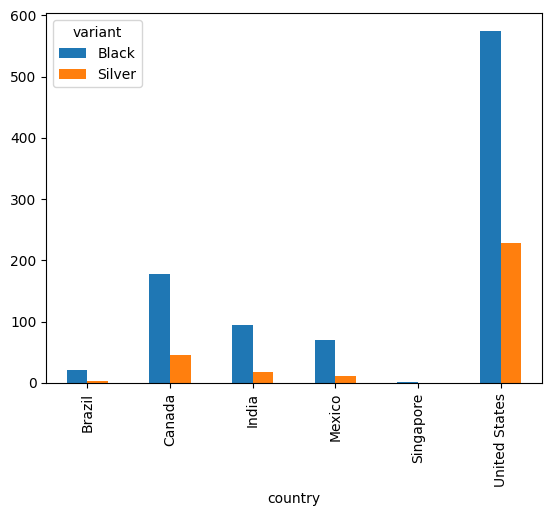

In [9]:
#review counts by locations and map the location by the review intensity
sony_location_grouped = sony_clean.groupby(['country', 'variant']).agg(review_count = ('position', 'count'), review_desc = ('reviewDescription', lambda x: ' '.join(x)))
sony_location_grouped['review_count'].unstack(level=1).plot(kind='bar')

### This plot displays the countries from which reviewers posted their opinions on Amazon about the Sony WH-1000XM5 headphones

**Findings:**
- Majority of written reviews for the Sony WH-1000XM5 headphones are from the United States, with other countries accounting for less than half of the total reviews.
- The black version of the headphones has a higher number of reviews than the white version. This may suggest that the black version is more popular and/or more commonly purchased online than the white version.


## SENTIMENT ANALYSIS

Building on what we have done in the previous section, we will be using the Natural Language Toolkit's VADER (Valence Aware Dictionary and sEntiment Reasoner) to calculate the compound score. The compound score represents the overall sentiment of the text, ranging from -1 (extremely negative) to 1 (extremely positive), with 0 representing a neutral sentiment. 

In [10]:
#necessary modules
import numpy as np
sid = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))
lem = WordNetLemmatizer()

### DISTRIBUTION OF POSITIVE AND NEGATIVE REVIEWS

To analyze the sentiment of users towards our product, we can classify the review comments into positive and negative categories based on their compound score. Since the review titles are typically shorter and more concise, we can use them to determine the overall sentiment of each review entry. If the compound score is less than 0, we can classify the review as negative, and if it is greater than 0, we can classify it as positive

In [11]:
#sony_clean['reviewTitle'] = sony_clean['reviewTitle'].str.lower()
sony_clean['title_compound_score'] = sony_clean['reviewTitle'].apply(lambda x: sid.polarity_scores(x)['compound'])
sony_clean['overall_sentiment'] = sony_clean['title_compound_score'].apply(lambda x: 'Positive' if x > 0 else 'Negative'if x < 0 else 'Neutral')

In [12]:
sony_clean.head(10)

,username,ratingScore,reviewTitle,date,country,reviewDescription,isVerified,variant,position,title_compound_score,overall_sentiment
0,kcdkcd,4,"Not bad, but I expected a little better if I'm...",2023-02-10,United States,I'm a hobbyist musician and sound engineer of ...,True,Black,1,0.8685,Positive
1,Bast,5,"Smaller heads, folks with hair, and sensitive ...",2023-01-18,United States,"First off, I havent had a chance to test all f...",True,Black,2,0.0000,Neutral
2,Richard HuynhRichard Huynh,5,Sony never disappoints!,2022-11-24,United States,I thoroughly enjoy what Sony has to offer in t...,True,Black,3,0.3561,Positive
3,mhans311,4,Comparison to Bose NC700,2023-02-04,United States,"I have used Bose NC700 for the past year, but ...",True,Silver,4,0.0000,Neutral
4,Fresh and Felicia,5,"UNBELIEVABLE carbon fiber sound quality, impro...",2022-05-24,United States,"I own Sony’s WH-1000 XM4s and the Bose 700s, t...",True,Black,5,0.8286,Positive
5,Worm,4,It’s not 100% Noise Cancellation,2023-01-16,United States,"If you want 100% Noise Cancellation, use ear p...",True,Black,6,0.0000,Neutral
6,Laurent Park,4,Incredibly comfortable and versatile headphone...,2023-02-04,United States,I got this looking for a replacement for my Ai...,True,Silver,7,0.6697,Positive
7,Miki Villarreal,5,I have fallen in love,2022-12-21,United States,I have been looking for some good over the ear...,True,Silver,8,0.4019,Positive
8,Brandi J.,5,The best headphones I've ever owned,2023-02-01,United States,I went ahead and splurged on these around 3 to...,True,Black,9,0.6369,Positive
9,Blayre C.,5,"Yep, buy them. Just do it.",2023-02-03,United States,If you're thinking about buying a pair of grea...,True,Black,10,0.2960,Positive


### DISTRIBUTION OF REVIEW SENTIMENTS

In [13]:
pos_neg = pd.DataFrame(sony_clean['overall_sentiment'].value_counts())

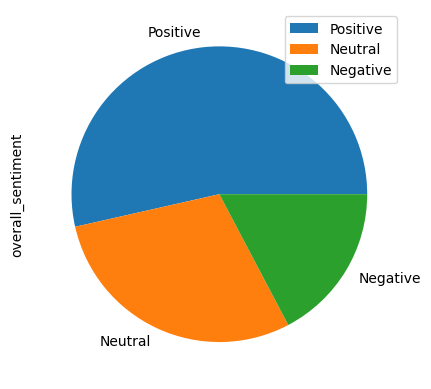

In [14]:
pos_neg.plot(kind='pie', subplots=True)
plt.legend(loc='upper right')

**Findings:**

- We can see that on row level, most of the review headings are positive with more than half of the total reviews.

### AVERAGE SENTIMENT OVERTIME

To gain insight into the product's overall sentiment since its launch, we will compute the average compound score on review heading for each date and examine the resulting trend. 

The function for this process is provided below.

In [15]:
#total reviews counts and overall sentiment overtime 
def get_sentiment_listofsen(textlist):
    compound_score = []
    
    for sentence in textlist:
        score =  sid.polarity_scores(sentence)['compound']
        compound_score.append(score)
        
    avg_score = np.mean(compound_score)
    
    return avg_score


def get_time_series(data):
    review_overtime = data.groupby(['date']).agg(average_rating = ('ratingScore', 'mean'), review_count = ('position', 'nunique'), review_title = ('reviewTitle', lambda x: ' '.join(x)))
    review_overtime['review_title'] = review_overtime['review_title'].apply(lambda x: sent_tokenize(x))                   
    review_overtime['average_score'] = review_overtime['review_title'].apply(lambda x: get_sentiment_listofsen(x))
    return review_overtime
    
sony_timeseries = get_time_series(sony_clean)


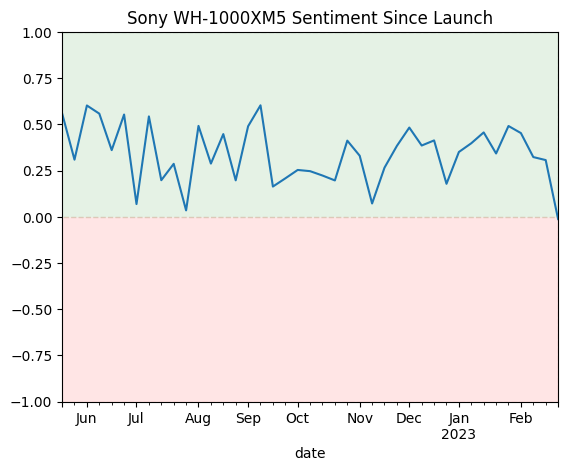

In [16]:
from datetime import datetime

x = x = [datetime(2022,1,1) , datetime(2023,2,20)]

sony_timeseries['average_score'].resample('W').mean().plot(kind='line')
plt.title('Sony WH-1000XM5 Sentiment Since Launch')
plt.fill_between(x=x,y1=0,y2=1, color='green', alpha=0.1, linestyle='--')
plt.fill_between(x=x,y1=0,y2=-1, color='red', alpha=0.1, linestyle='--')
plt.ylim(-1,1)
plt.show()

**Findings:**
- We can see that the compound score of Sony WH-1000XM5 (resampled into weekly average) has been moderately positive at between 0 and 0.5 and stable since the launch date.

## SENTIMENT ANALYSIS BY PRODUCT FEATURE

Based on our analysis of the most frequently mentioned words in the reviews, it would be useful to determine whether these words are spoken of positively or negatively. 

**However, there is one issue to consider. Given that one reviewers may mention both the pros and cons of the product, calculating the sentiment score for the entire paragraph may not be accurate. For example, a customer may mention excellent sound quality while expressing concerns about the headphone materials.**

I approached this task by isolating sentences that solely express a specific review of a particular feature of the product. This method enables me to obtain the most accurate sentiment for each product feature. 

To isolate the sentiment for each product feature, I began by extracting sentences that express specific reviews about the feature. To achieve this, I utilized the sent_tokenize() function from the NLTK library to split the reviews into individual sentences. Next, I calculated the sentiment score for each sentence instead of the entire review paragraph.For instance, if you are interested in evaluating the sentiment about the material quality of a headphone, only sentences that relate to the material quality should be extracted.


The function code is shown below:

The function will require 3 arguments, the dataset, the column containing the review, and the product feature keyword we want to isolate. It will then calculate compound score the relevant sentences and average them.

For example the function below, take a sentences that contain feature keyword "material" to get the review about the product build quality.

In [17]:
import regex as re
def get_kwaverage_sentiment(data, text, topic):
 
# Calculate the sentiment scores and compound score for each instance of each word in the reviews statement
    
    #storing a list of compound scores into a dict
    sentences_group = []
    compound_scores = []
    
    #review in each entries
    for review in data[text]:
        
        token_sentence = sent_tokenize(review)

    	#loop through each sentence
        for sentence in token_sentence:
            
            #if a sentence contains a topic word
            if re.search(topic, sentence, re.IGNORECASE):

                #if found match sentence then get the compound range and append to the compound scores
                word_score =  sid.polarity_scores(sentence)['compound']
                sentences_group.append(sentence)
                compound_scores.append(word_score)

    return [compound_scores, sentences_group]

Once we have a function to extract sentiment, we need to identify the specific product features we are interested in. For this analysis, we are mainly concerned with sound quality, materials used, battery life, and other use cases. 

The following keywords can be added to the list for the function to loop through and extract sentiment
- Sound
- Noise cancelling 
- Materials
- Battery
- Durability
- Comfort
- Price
- Product Design
- Connectivity
- User Interface

In [18]:
keyword_lists = {
    'sound': r'sound',
    'noise_cancellation': r'noise cancell',
    'material': r'material',
    'battery': r'batter\w+',
    'durability': r'durab\w+',
    'comfort': r'comf\w+',
    'price': r'pric\w+',
    'design': r'design\w+',
    'connectivity': r'connect\w+',
    'user_interface': r'interface.+?'
}

In [19]:
features_avg_score = []
sentences_list = []
pos_or_neg = []


for k,v in keyword_lists.items():
    features_avg_score.append(get_kwaverage_sentiment(sony_clean, 'reviewDescription', v)[0])    
    sentences_list.append(get_kwaverage_sentiment(sony_clean, 'reviewDescription', v)[1])

After obtaining the desired data sets, we can merge them to create a data frame. This data frame should include a list of sentences along with their respective sentiment scores, the number of sentences analyzed, and the average compound score for each feature.

In [20]:
features_avg_score = list(zip(keyword_lists.keys(),sentences_list,features_avg_score))

In [21]:
sentiment_table = pd.DataFrame(features_avg_score, columns=['feature_keyword', 'sentences','all_scores'])

In [22]:
sentiment_table

,feature_keyword,sentences,all_scores
0,sound,[I'm a hobbyist musician and sound engineer of...,"[0.0, -0.0387, 0.1901, 0.8807, 0.8849, 0.4995,..."
1,noise_cancellation,"[Due to their small form factor, IEM's can use...","[0.9398, 0.3164, 0.5106, 0.6996, 0.3612, 0.758..."
2,material,[Biggest issue now is the band material is not...,"[0.0, 0.7677, 0.8832, 0.0, 0.6369, -0.5321, 0...."
3,battery,[I enjoy these so much that I'm actually glad ...,"[0.7574, -0.2924, 0.7677, -0.6652, 0.0, -0.659..."
4,durability,"[He loves the sound quality, battery life, th...","[0.6124, 0.8614, 0.6249, 0.0, 0.8779, 0.6908, ..."
5,comfort,[I did have to restart my computer to get Wind...,"[0.8807, 0.4404, 0.8607, -0.3182, 0.9131, 0.65..."
6,price,"[Needless to say, the imaging, and extension o...","[0.4404, 0.0, -0.1279, 0.7579, 0.7684, -0.6597..."
7,design,[These are not designed for exercise or heavy ...,"[0.0, 0.8271, 0.7677, 0.8825, 0.9805, 0.0, 0.4..."
8,connectivity,[I did have to restart my computer to get Wind...,"[0.8807, 0.3612, 0.296, -0.3182, 0.0, -0.1531,..."
9,user_interface,[I bought these headphones and completely fell...,"[0.0935, 0.4404, 0.3832, 0.6249, 0.754, 0.2023..."


Furthermore, I have included a function that assigns a sentiment category to each of the compound scores in the list. If the compound score is greater than or equal to 0.05, it is classified as positive. If it is less than -0.05, it is classified as negative. If the compound score is between -0.05 and 0.05, it is classified as neutral.

In [23]:
def pos_neg(list_num):
    posneg = []
    for i in list_num:
        if i >= 0.05:
            posneg.append('positive')
        elif i <= -0.05:
            posneg.append('negative')
        else:
            posneg.append('neutral')
    return posneg

The result table is displayed below

In [24]:
sentiment_table['counts'] =  sentiment_table['all_scores'].apply(lambda x: len(x))

sentiment_table['mean_avg_score'] = sentiment_table['all_scores'].apply(lambda x: round(np.mean(x),2))

sentiment_table['posneg_list'] = sentiment_table['all_scores'].apply(lambda x: pos_neg(x))

sentiment_table = sentiment_table.sort_values('counts', ascending= False)

sentiment_table

,feature_keyword,sentences,all_scores,counts,mean_avg_score,posneg_list
0,sound,[I'm a hobbyist musician and sound engineer of...,"[0.0, -0.0387, 0.1901, 0.8807, 0.8849, 0.4995,...",1063,0.38,"[neutral, neutral, positive, positive, positiv..."
1,noise_cancellation,"[Due to their small form factor, IEM's can use...","[0.9398, 0.3164, 0.5106, 0.6996, 0.3612, 0.758...",496,0.30,"[positive, positive, positive, positive, posit..."
5,comfort,[I did have to restart my computer to get Wind...,"[0.8807, 0.4404, 0.8607, -0.3182, 0.9131, 0.65...",454,0.42,"[positive, positive, positive, negative, posit..."
3,battery,[I enjoy these so much that I'm actually glad ...,"[0.7574, -0.2924, 0.7677, -0.6652, 0.0, -0.659...",197,0.37,"[positive, negative, positive, negative, neutr..."
6,price,"[Needless to say, the imaging, and extension o...","[0.4404, 0.0, -0.1279, 0.7579, 0.7684, -0.6597...",196,0.26,"[positive, neutral, negative, positive, positi..."
8,connectivity,[I did have to restart my computer to get Wind...,"[0.8807, 0.3612, 0.296, -0.3182, 0.0, -0.1531,...",191,0.13,"[positive, positive, positive, negative, neutr..."
2,material,[Biggest issue now is the band material is not...,"[0.0, 0.7677, 0.8832, 0.0, 0.6369, -0.5321, 0....",63,0.26,"[neutral, positive, positive, neutral, positiv..."
4,durability,"[He loves the sound quality, battery life, th...","[0.6124, 0.8614, 0.6249, 0.0, 0.8779, 0.6908, ...",20,0.44,"[positive, positive, positive, neutral, positi..."
7,design,[These are not designed for exercise or heavy ...,"[0.0, 0.8271, 0.7677, 0.8825, 0.9805, 0.0, 0.4...",15,0.18,"[neutral, positive, positive, positive, positi..."
9,user_interface,[I bought these headphones and completely fell...,"[0.0935, 0.4404, 0.3832, 0.6249, 0.754, 0.2023...",7,0.34,"[positive, positive, positive, positive, posit..."


### VISUALIZE THE SENTIMENT BY PRODUCT FEATURES

After merging the datasets, we can analyze the frequency of features mentioned in the reviews by creating a bar graph. 

### Compound scores by features

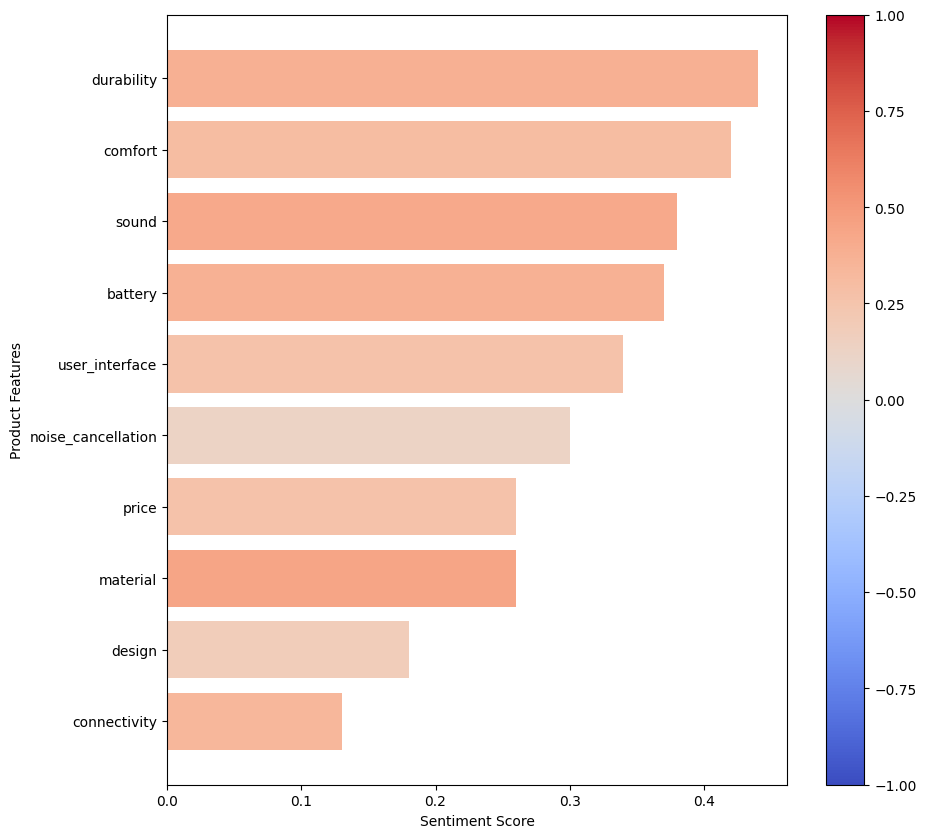

In [30]:
sentiment_table_sortbyscore = sentiment_table.sort_values('mean_avg_score', ascending=False)

norm = Normalize(vmin=-1, vmax=1)
color_values = norm(sentiment_table['mean_avg_score'])
mappable = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)

plt.figure(figsize=(10,10))
plt.barh(sentiment_table_sortbyscore['feature_keyword'],sentiment_table_sortbyscore['mean_avg_score'], color=cm.coolwarm(color_values))
plt.gca().invert_yaxis()
plt.xlabel('Sentiment Score')
plt.ylabel('Product Features')
plt.colorbar(mappable)

### Frequencies of the mentions by features

Text(0, 0.5, 'Product Features')

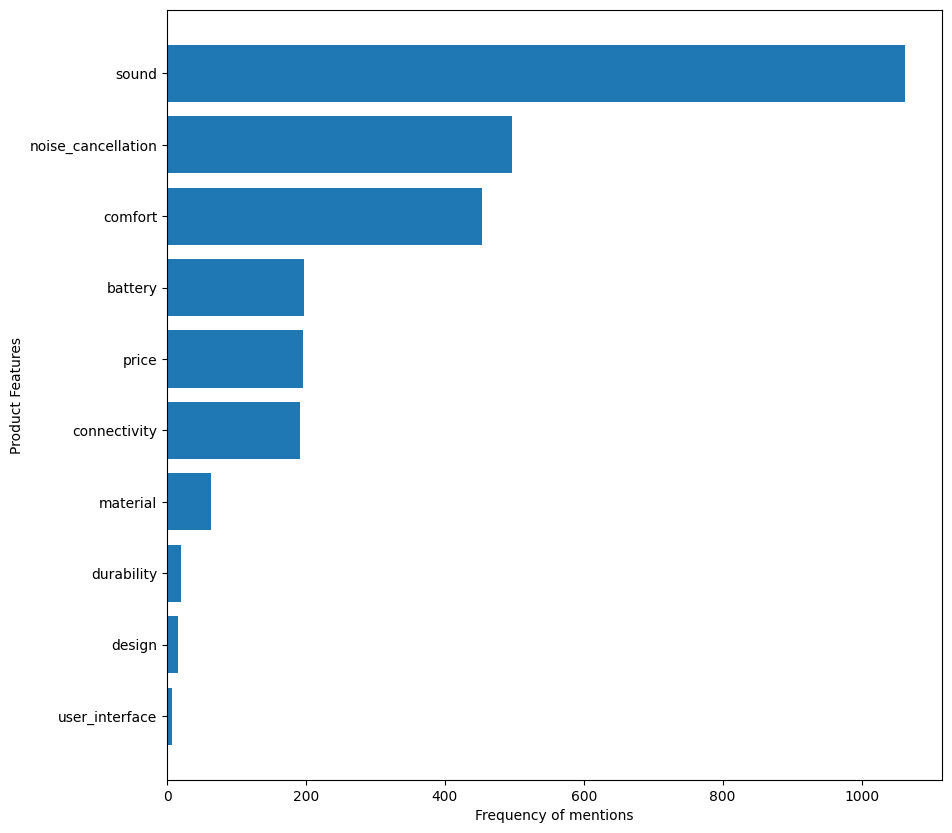

In [26]:
norm = Normalize(vmin=-1, vmax=1)
color_values = norm(sentiment_table['mean_avg_score'])
mappable = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)


plt.figure(figsize=(10,10))
plt.barh(sentiment_table['feature_keyword'],sentiment_table['counts'])
plt.gca().invert_yaxis()
plt.xlabel('Frequency of mentions')
plt.ylabel('Product Features')

#plt.colorbar(mappable) , color=cm.coolwarm(color_values))

**Findings:**

- According to the analysis of our merged dataset, the feature that has been mentioned the most in the reviews is the sound quality of the headphones, with over 1000 mentions. The next most frequently mentioned also a sound-related feature which is noise cancellation almost 500 mentiones.

Next, let's conduct a more detailed analysis and examine the distribution of positive, negative, and neutral mentions for each feature. This will allow us to determine if there are any features that are more likely to receive one type of mentions over the others.

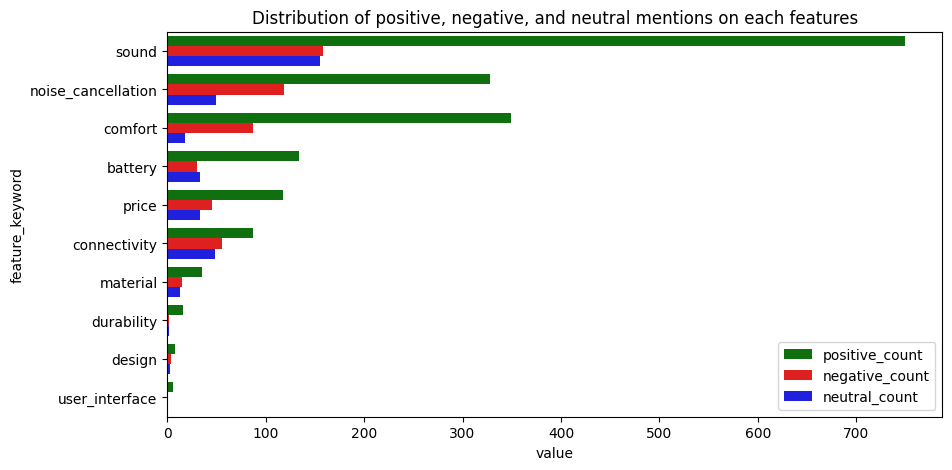

In [27]:
df = sentiment_table[['feature_keyword', 'posneg_list']]
df['positive_count'] = df['posneg_list'].apply(lambda x: x.count('positive'))
df['negative_count'] = df['posneg_list'].apply(lambda x: x.count('negative'))
df['neutral_count'] =  df['posneg_list'].apply(lambda x: x.count('neutral'))
melt_df = pd.melt(df, id_vars=['feature_keyword', 'posneg_list'])
melt_df[['feature_keyword', 'variable', 'value']]

plt.figure(figsize=(10,5))

sns.barplot(data=melt_df, x="value", y="feature_keyword", hue="variable", palette=["g", "r", "b"])
plt.title('Distribution of positive, negative, and neutral mentions on each features')
plt.legend(loc='lower right')

**Findings:**

- It appears that the majority of mentions regarding features that received a significant amount of attention are positive in nature.

### **CONCLUSIONS**

- Based on the dataset given, all analysis and findings most of the reviews either by each entry or by classification of the the product features reveal that Sony WH-1000XM5 has been well-recieved by customers.

- Most of the widely disscussed features are in product sound quality and it noise cancelling technology evident in disproportionately high number of mentions across all reviews.

- Unfortunately due to limited number of review result in uneven number of review on each assigned product feature,there is a limit on the overall reliability and generalizability of the findings. more additional research or data collection to fill in the gaps and provide a more comprehensive analysis are necessary

### LIMITATIONS


- While acknowledging that the dataset may be too limited to draw broad conclusions about the overall public opinion of Sony's latest headphones, it is still valuable to conduct analysis on the available data. Through this analysis, we can identify the strengths and weaknesses of the product, which can be utilized to inform future product improvements.

- While VADER is a useful tool for sentiment analysis, it does have limitations that should be considered. One limitation of VADER is that it takes sentences at face value and does not account for nuances such as sarcasm and other forms of expressive language. Additionally, some of the paragraphs did not splitted properly with tokenizer.

- Relying solely on a fixed feature keyword to choose relevant sentences might be limiting, as it may exclude sentences that reference the product feature indirectly or in a different context.

- It is important to note that there could be inaccuracies in our analysis if some features are mentioned significantly less often than others. This could cause the sentiment score for a particular feature to be over or under exaggerated, making it unreliable to conclude the analysis.
